# Compare alternative decision making methods on a value diagram

In [36]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *
from ruv.helpers import *

In [39]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark_blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### Day 1 to 7 forecasts for catchment in southern Murray-Darling basin generated using the MuTHRE method

In [40]:
awrc = '401012'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 8
alpha_step = 0.01

In [41]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'].T, data['fcst'].T
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 484)


# Define decision context

In [42]:
decision_threshold = np.nanquantile(obs, 0.75)

decision_definition = {
    'alphas': np.arange(alpha_step, 1, alpha_step),
    'damage_function': [binary, {'max_loss': 1, 'min_loss': 0, 'threshold': decision_threshold}],        
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': np.insert([decision_threshold], 0, 0),
    'event_freq_ref': True
}

ref = clim_ens

# What does the data look like?

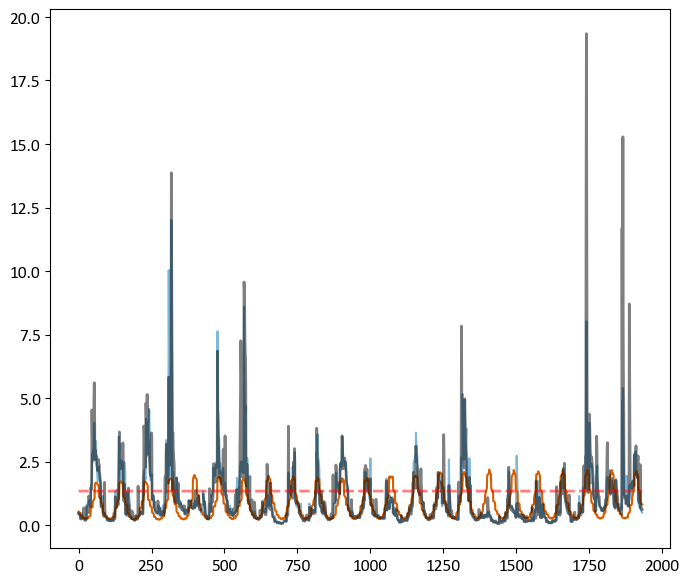

In [43]:
thres = 0.5
fcst_plt = np.quantile(fcst_ens, thres, axis=1)
ref_plt = np.quantile(clim_ens, thres, axis=1)

plt.plot(fcst_plt.T, color=colors['dark_blue'], alpha=0.5)
plt.plot(ref_plt.T, color=colors['dark_orange'], alpha=1)
plt.plot(obs, color=colors['black'], linewidth=2, alpha=0.5)
plt.plot(decision_threshold * np.ones(obs.shape), color='red', linewidth=2, linestyle='--', alpha=0.5)

# Calculate RUV using different decision-making methods

In [44]:
# 'optimise_over_forecast_distribution' decision method is the default
decision_definition['decision_method'] = 'optimise_over_forecast_distribution'
results_optim = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [45]:
decision_definition['decision_method'] = 'critical_probability_threshold_fixed'

decision_definition['critical_probability_threshold'] = 0.1
results_fixed_10th = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

decision_definition['critical_probability_threshold'] = 0.5
results_fixed_50th = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

decision_definition['critical_probability_threshold'] = 0.9
results_fixed_90th = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [46]:
decision_definition['decision_method'] = 'critical_probability_threshold_max_value'
results_max = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [47]:
decision_definition['decision_method'] = 'critical_probability_threshold_equals_alpha'
results_alpha = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

# Plot results on a value diagram

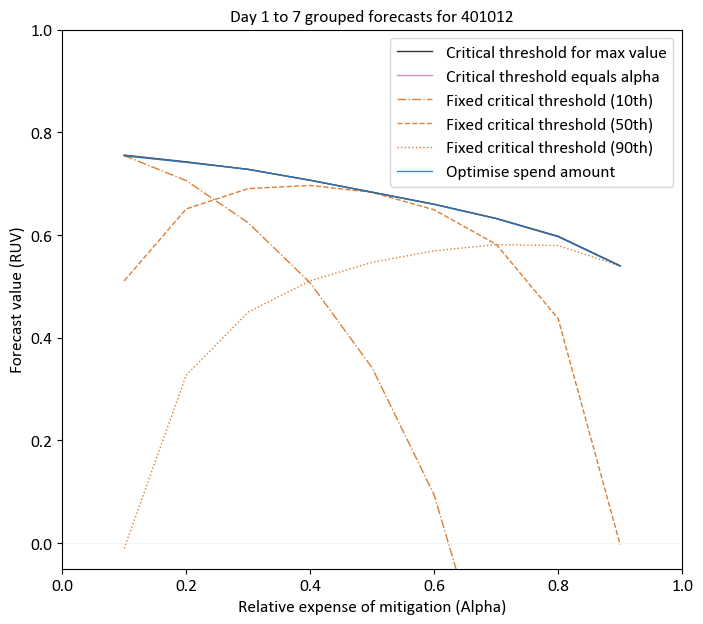

In [49]:
plt.plot(decision_definition['alphas'], results_max['ruv'], color=colors['black'], linewidth=1, alpha=0.8, label='Critical threshold for max value')
plt.plot(decision_definition['alphas'], results_alpha['ruv'], color=colors['pink'], linewidth=1, alpha=0.8, label='Critical threshold equals alpha')
plt.plot(decision_definition['alphas'], results_fixed_10th['ruv'], color=colors['dark_orange'], linestyle='-.', linewidth=1, alpha=0.8, label='Fixed critical threshold (10th)')
plt.plot(decision_definition['alphas'], results_fixed_50th['ruv'], color=colors['dark_orange'], linestyle='--', linewidth=1, alpha=0.8, label='Fixed critical threshold (50th)')
plt.plot(decision_definition['alphas'], results_fixed_90th['ruv'], color=colors['dark_orange'], linestyle=':', linewidth=1, alpha=0.8, label='Fixed critical threshold (90th)')
plt.plot(decision_definition['alphas'], results_optim['ruv'], color=colors['dark_blue'], linewidth=1, alpha=0.8, label='Optimise spend amount')
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.xlim((0, 1))
plt.ylim(-0.05, 1)
plt.xlabel('Relative expense of mitigation (Alpha)')
plt.ylabel('Forecast value (RUV)') 
plt.title('Day 1 to 7 grouped forecasts for %s' % awrc, fontsize='medium')
plt.legend()